In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Part 1 — Non-Linear Regression

## Part 1 - A

In this section, we study the behavior of polynomial regression and ridge regularization when fitting a non-linear function.  
We will examine how different values of the regularization parameter λ affect model generalization, especially under a Leave-One-Out Cross-Validation (LOOCV) evaluation.

### Generating the Dataset

We generate **25 data points** using the function:

\[
y = sin(5 𝜋 xi) + 𝜀!
\]

where:
- \( x  ∈ (0, 1) \)
- \( 𝜀! ∈ (-0.3, 0.3) \)

We then build polynomial features up to degree 9, producing:

\[
X = [1, x, x^2, ..., x^9]
\]

Finally, we hold out **5 examples** as a final **test set**, leaving **20 examples** for training and cross-validation.

In [2]:
np.random.seed(42)

n = 25
degree = 9

x = np.random.rand(n) # 25 random number between 0 and 1
eps = np.random.uniform(-0.3, 0.3, n) # 25 random noise betwen -0.3 and 0.3

y = np.sin(5 * np.pi * x) + eps # the true value of each of the 25 examples
X = np.column_stack([x**k for k in range(degree + 1)]) # matrix of 25*10 (the firs row is: 1, x[0], x[0]^2, ... , x[0]^9)

"""
x → random numbers between 0 and 1 (25,)

y → the true value of each of the 25 examples (25,)

X → features matrix (25,10)

X_temp → training features (20, 10)

X_test → test features (5, 10)

y_temp → training targets (20,)

y_test → test targets (5,)

x_temp → training x values (20,) 

x_test → test x values (5,) 
"""
X_temp, X_test, y_temp, y_test, x_temp, x_test = train_test_split(
    X, y, x, test_size=5, random_state=2)

X_temp.shape, X_test.shape

((20, 10), (5, 10))

### Leave-One-Out Cross-Validation (LOOCV)

Since our dataset is very small, using a traditional train/validation split would be unreliable because the validation set may end up being too noisy.
Instead, for each value of λ, we perform LOOCV on the 20 non-test points:

1. Leave out one point for validation  
2. Train on the remaining 19  
3. Compute the squared error on the held-out point  
4. Repeat for all 20 points  
5. Average the validation errors to obtain the LOOCV error for that λ  

This process provides a more stable and unbiased estimate of model performance.

In [3]:
lambdas = [0, 0.01, 0.1, 1, 10]
cv_errors = {}

X_cv = X_temp
y_cv = y_temp
x_cv = x_temp

for lam in lambdas:
    errors = []

    for i in range(len(X_cv)):
        X_train = np.delete(X_cv, i, axis=0)
        y_train = np.delete(y_cv, i, axis=0)

        X_val = X_cv[i].reshape(1, -1)
        y_val = y_cv[i]

        model = Ridge(alpha=lam, fit_intercept=False)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        errors.append((y_val - y_pred[0])**2)

    cv_errors[lam] = np.mean(errors)

cv_errors

{0: 6.8395387620163195,
 0.01: 0.44314924423521607,
 0.1: 0.4273081767650411,
 1: 0.4140524468736487,
 10: 0.4037589315949086}

### Selecting the Best Regularization Parameter λ

We compute CV_MSE for each tested value of λ.  
The λ with the lowest LOOCV error is chosen as the **optimal regularization strength**.

In [4]:
best_lambda = min(cv_errors, key=cv_errors.get)
best_lambda

10

### Training the Final Model

Using the best λ from LOOCV, we refit the model on all 20 training set examples.  
This gives the model the maximum amount of training data while still preserving an unbiased estimate of λ.

In [5]:
final_model = Ridge(alpha=best_lambda, fit_intercept=False)
final_model.fit(X_cv, y_cv)

,alpha,10
,fit_intercept,False
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


### Evaluating on the Testing Set

We now evaluate the chosen model on the 5 completely unseen test examples.  
This provides the **true generalization error** of our final model.

In [6]:
y_pred_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mse

0.21841123603351856

### Plotting the Polynomial Fits for Different λ

Here we visualize how the ridge regression model behaves for different λ values.  
- Small λ → flexible, wiggly curves (risk of overfitting)  
- Large λ → smoother, more biased curves  

The plot overlays:
- The 20 training examples (blue)
- The 5 testing examples (red)
- The fitted curves for each λ

This allows us to visually compare model smoothness and stability.

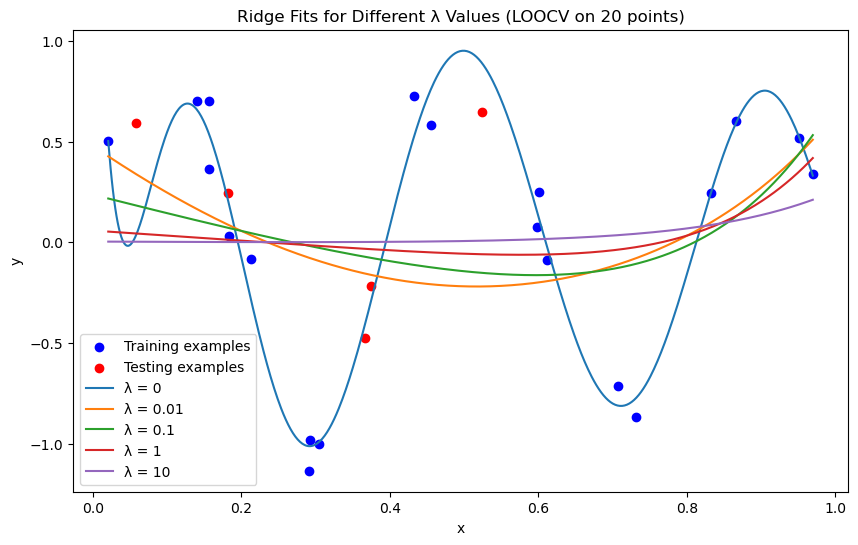

In [7]:
plt.figure(figsize=(10,6))

plt.scatter(x_cv, y_cv, color='blue', label='Training examples')
plt.scatter(x_test, y_test, color='red', label='Testing examples')

grid = np.linspace(x.min(), x.max(), 600)
X_grid = np.column_stack([grid**k for k in range(degree + 1)])

for lam in lambdas:
    model = Ridge(alpha=lam, fit_intercept=False)
    model.fit(X_cv, y_cv)
    y_pred_grid = model.predict(X_grid)
    plt.plot(grid, y_pred_grid, label=f"λ = {lam}")

plt.title("Ridge Fits for Different λ Values (LOOCV on 20 points)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Summary of Results

We print:

- The LOOCV MSE for each λ  
- The selected best λ  
- The final test MSE  

These values allow us to quantify:
- How each λ performed during cross-validation  
- How well the chosen model generalizes to new data  

In [8]:
print("LOOCV Errors:")
for lam, err in cv_errors.items():
    print(f"lambda = {lam:<5}   CV MSE = {err:.6f}")

print("\nBest lambda:", best_lambda)
print("Final Test MSE:", test_mse)

LOOCV Errors:
lambda = 0       CV MSE = 6.839539
lambda = 0.01    CV MSE = 0.443149
lambda = 0.1     CV MSE = 0.427308
lambda = 1       CV MSE = 0.414052
lambda = 10      CV MSE = 0.403759

Best lambda: 10
Final Test MSE: 0.21841123603351856


##  Part 1 - B

In this section, we will apply non-linear regression (without regularization) on the same
generated set S using different numbers of Radial Basis Functions.

Matrix Representation of RBF Features

$$
Z = 
\begin{bmatrix}
1 & z_1(x_1) & z_2(x_1) & \dots & z_M(x_1) \\
1 & z_1(x_2) & z_2(x_2) & \dots & z_M(x_2) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & z_1(x_N) & z_2(x_N) & \dots & z_M(x_N)
\end{bmatrix}
$$

where each RBF is defined as:

$$
z_j(x_i) = \exp\Big(-\frac{(x_i - \alpha_j)^2}{\lambda}\Big)
$$

with:  
- $N$ the number of examples  
- $M$ the number of RBFs  
- $\alpha_j$ the center of the $j$-th RBF  
- $\lambda$ controls the width of the RBF


After constructing the design matrix \(Z\) using RBF features, we can find the optimal weights \(w\) by minimizing the squared error between predictions and targets:

$$
w = \arg\min_w \| y - Z w \|^2
$$

The solution can be computed using the normal equation:

$$
w = (Z^T Z)^{-1} Z^T y
$$


As before, we split the dataset into a **training set** and a **testing set**, with **20 examples** for training and **5 examples** for testing.

It is better to choose lamba for each model, instead of choosing a fixed one because......


In [101]:
"""
x → random numbers between 0 and 1 (25,)

y → the true value of each of the 25 examples (25,)

X → features matrix (25,10)

X_temp → training features (20, 10)

X_test → test features (5, 10)

y_temp → training targets (20,)

y_test → test targets (5,)

x_temp → training x values (20,) 

x_test → test x values (5,) 
"""
X_temp, X_test, y_temp, y_test, x_temp, x_test = train_test_split(
    X, y, x, test_size=5, random_state=1)

# RBF function
def RBF(x, alpha, _lambda):
    return np.exp(-(x - alpha)**2 / _lambda)

RBFs = []
MSEs = []
Lambdas = []

### 1 RBF basis function

#### Lambda = 0.01

0.5


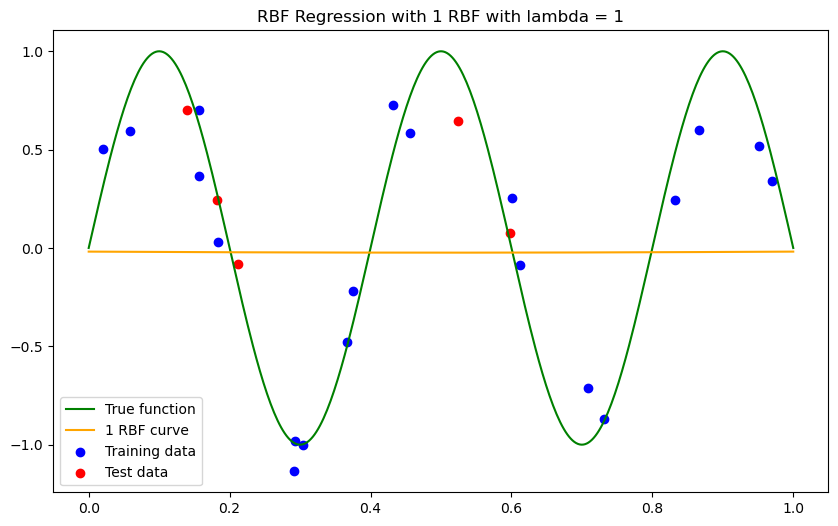

Test MSE: 0.21083246011340986


In [102]:
# RBF parameters
M = 1
_lambda = 1
alphas = np.array([0.5]) # since M=1, we need the center to be 0.5

print(alphas[0])

# Build the Z matrix for the training examples
Z_train = np.column_stack([RBF(x_temp, a, _lambda) for a in alphas])

# find w that gives the least mean square error
w, *_ = np.linalg.lstsq(Z_train, y_temp, rcond=None)

# Predict on training set
y_train_pred = Z_train @ w

# Predict on test set
Z_test = np.column_stack([RBF(x_test, a, _lambda) for a in alphas])
y_test_pred = Z_test @ w

# Predict for smooth curve
xx = np.linspace(0, 1, 400)
Z_xx = np.column_stack([RBF(xx, a, _lambda) for a in alphas])
y_smooth = Z_xx @ w

# Plot
plt.figure(figsize=(10,6))
plt.plot(xx, np.sin(5*np.pi*xx), label="True function", color='green')
plt.plot(xx, y_smooth, label=f"{M} RBF curve", color='orange')
plt.scatter(x_temp, y_temp, color='blue', label="Training data")
plt.scatter(x_test, y_test, color='red', label="Test data")
plt.legend()
plt.title(f"RBF Regression with {M} RBF with lambda = {_lambda}")
plt.show()

# Test MSE
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_test}")

MSEs.append(mse_test)
Lambdas.append(_lambda)
RBFs.append(M)


#### Lambda = 0.5

0.5


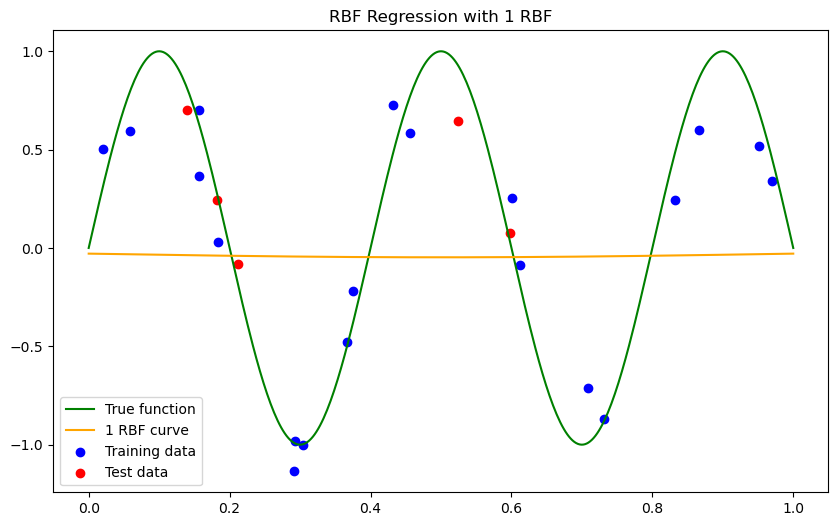

Test MSE: 0.2244339740589909


In [103]:
# RBF parameters
M = 1
_lambda = 0.5
alphas = np.linspace(1/(M+1), M/(M+1), M)

print(alphas[0])

# Build the Z matrix for the training examples
Z_train = np.column_stack([RBF(x_temp, a, _lambda) for a in alphas])

# find w that gives the least mean square error
w, *_ = np.linalg.lstsq(Z_train, y_temp, rcond=None)

# Predict on training set
y_train_pred = Z_train @ w

# Predict on test set
Z_test = np.column_stack([RBF(x_test, a, _lambda) for a in alphas])
y_test_pred = Z_test @ w

# Predict for smooth curve
xx = np.linspace(0, 1, 400)
Z_xx = np.column_stack([RBF(xx, a, _lambda) for a in alphas])
y_smooth = Z_xx @ w

# Plot
plt.figure(figsize=(10,6))
plt.plot(xx, np.sin(5*np.pi*xx), label="True function", color='green')
plt.plot(xx, y_smooth, label=f"{M} RBF curve", color='orange')
plt.scatter(x_temp, y_temp, color='blue', label="Training data")
plt.scatter(x_test, y_test, color='red', label="Test data")
plt.legend()
plt.title(f"RBF Regression with {M} RBF")
plt.show()

# Test MSE
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_test}")

MSEs.append(mse_test)
Lambdas.append(_lambda)
RBFs.append(M)


### 5 RBF basis functions

[0.16666667 0.33333333 0.5        0.66666667 0.83333333]


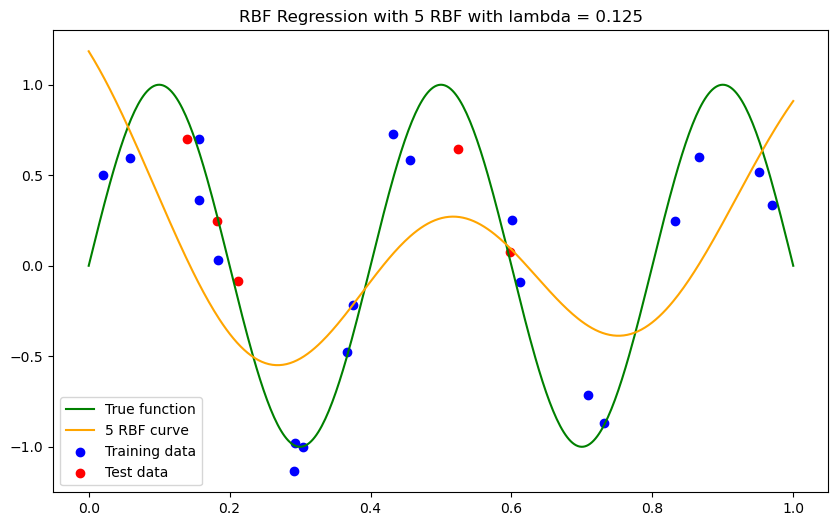

Test MSE: 0.19542535310681472


In [104]:
# RBF parameters
M = 5
_lambda = 0.125
alphas = np.linspace(1/(M+1), M/(M+1), M)
print(alphas)

# Build the Z matrix for the training examples
Z_train = np.column_stack([RBF(x_temp, a, _lambda) for a in alphas])

# find w that gives the least mean square error
w, *_ = np.linalg.lstsq(Z_train, y_temp, rcond=None)

# Predict on training set
y_train_pred = Z_train @ w

# Predict on test set
Z_test = np.column_stack([RBF(x_test, a, _lambda) for a in alphas])
y_test_pred = Z_test @ w

# Predict for smooth curve
xx = np.linspace(0, 1, 400)
Z_xx = np.column_stack([RBF(xx, a, _lambda) for a in alphas])
y_smooth = Z_xx @ w

# Plot
plt.figure(figsize=(10,6))
plt.plot(xx, np.sin(5*np.pi*xx), label="True function", color='green')
plt.plot(xx, y_smooth, label=f"{M} RBF curve", color='orange')
plt.scatter(x_temp, y_temp, color='blue', label="Training data")
plt.scatter(x_test, y_test, color='red', label="Test data")
plt.legend()
plt.title(f"RBF Regression with {M} RBF with lambda = {_lambda}")
plt.show()

# Test MSE
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_test}")

MSEs.append(mse_test)
Lambdas.append(_lambda)
RBFs.append(M)


### 10 RBF basis functions

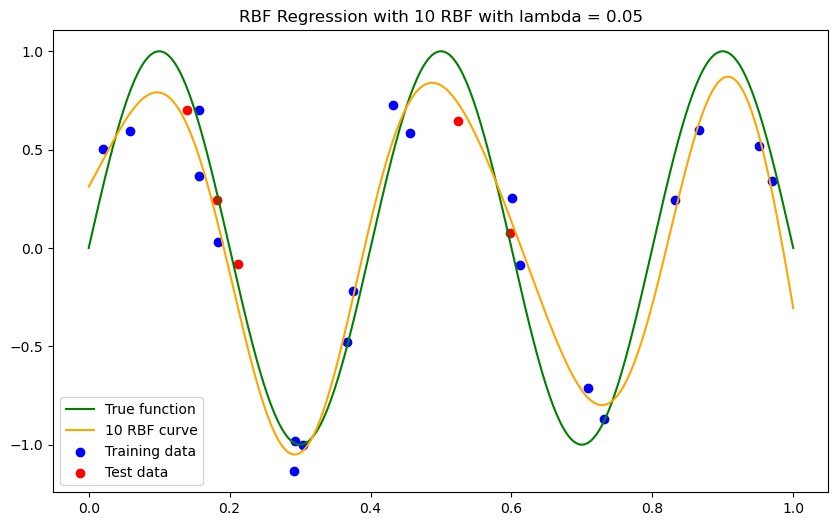

Test MSE: 0.016151366238639643


In [105]:
# RBF parameters
M = 10
_lambda = 0.05
alphas = np.linspace(1/(M+1), M/(M+1), M)

# Build the Z matrix for the training examples
Z_train = np.column_stack([RBF(x_temp, a, _lambda) for a in alphas])

# find w that gives the least mean square error
w, *_ = np.linalg.lstsq(Z_train, y_temp, rcond=None)

# Predict on training set
y_train_pred = Z_train @ w

# Predict on test set
Z_test = np.column_stack([RBF(x_test, a, _lambda) for a in alphas])
y_test_pred = Z_test @ w

# Predict for smooth curve
xx = np.linspace(0, 1, 400)
Z_xx = np.column_stack([RBF(xx, a, _lambda) for a in alphas])
y_smooth = Z_xx @ w

# Plot
plt.figure(figsize=(10,6))
plt.plot(xx, np.sin(5*np.pi*xx), label="True function", color='green')
plt.plot(xx, y_smooth, label=f"{M} RBF curve", color='orange')
plt.scatter(x_temp, y_temp, color='blue', label="Training data")
plt.scatter(x_test, y_test, color='red', label="Test data")
plt.legend()
plt.title(f"RBF Regression with {M} RBF with lambda = {_lambda}")
plt.show()

# Test MSE
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_test}")

MSEs.append(mse_test)
Lambdas.append(_lambda)
RBFs.append(M)

### 50 RBF basis functions

#### Lambda = 0.01

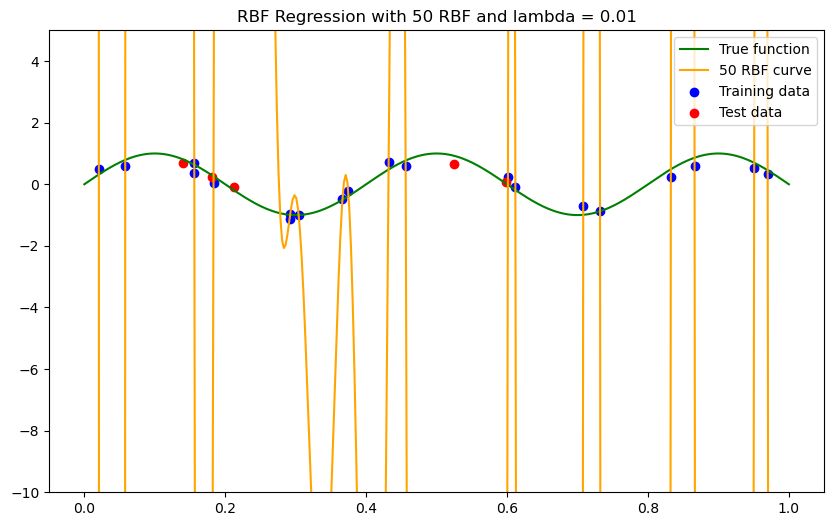

Test MSE: 923619.4975331908


In [106]:
# RBF parameters
M = 50
alphas = np.linspace(1/(M+1), M/(M+1), M)
_lambda = 0.01

# Build the Z matrix for the training examples
Z_train = np.column_stack([RBF(x_temp, a, _lambda) for a in alphas])

# find w that gives the least mean square error
w, *_ = np.linalg.lstsq(Z_train, y_temp, rcond=None)

# Predict on training set
y_train_pred = Z_train @ w

# Predict on test set
Z_test = np.column_stack([RBF(x_test, a, _lambda) for a in alphas])
y_test_pred = Z_test @ w

# Predict for smooth curve
xx = np.linspace(0, 1, 400)
Z_xx = np.column_stack([RBF(xx, a, _lambda) for a in alphas])
y_smooth = Z_xx @ w

# Plot
plt.figure(figsize=(10,6))
plt.plot(xx, np.sin(5*np.pi*xx), label="True function", color='green')
plt.plot(xx, y_smooth, label=f"{M} RBF curve", color='orange')
plt.scatter(x_temp, y_temp, color='blue', label="Training data")
plt.scatter(x_test, y_test, color='red', label="Test data")
plt.legend()
plt.ylim(-10,5)
plt.title(f"RBF Regression with {M} RBF and lambda = {_lambda}")
plt.show()

# Test MSE
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_test}")

MSEs.append(mse_test)
Lambdas.append(_lambda)
RBFs.append(M)


#### Lambda = 0.1

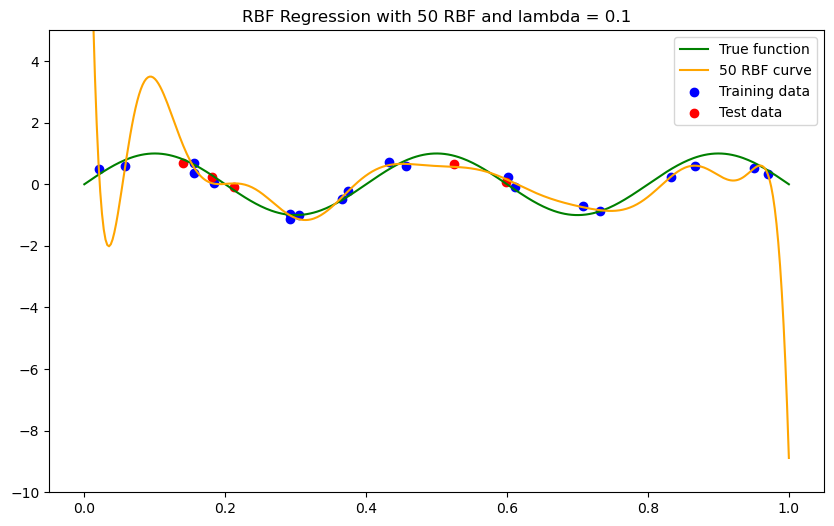

Test MSE: 0.0872917411961334


In [107]:
# RBF parameters
M = 50
alphas = np.linspace(1/(M+1), M/(M+1), M)
_lambda = 0.1

# Build the Z matrix for the training examples
Z_train = np.column_stack([RBF(x_temp, a, _lambda) for a in alphas])

# find w that gives the least mean square error
w, *_ = np.linalg.lstsq(Z_train, y_temp, rcond=None)

# Predict on training set
y_train_pred = Z_train @ w

# Predict on test set
Z_test = np.column_stack([RBF(x_test, a, _lambda) for a in alphas])
y_test_pred = Z_test @ w

# Predict for smooth curve
xx = np.linspace(0, 1, 400)
Z_xx = np.column_stack([RBF(xx, a, _lambda) for a in alphas])
y_smooth = Z_xx @ w

# Plot
plt.figure(figsize=(10,6))
plt.plot(xx, np.sin(5*np.pi*xx), label="True function", color='green')
plt.plot(xx, y_smooth, label=f"{M} RBF curve", color='orange')
plt.scatter(x_temp, y_temp, color='blue', label="Training data")
plt.scatter(x_test, y_test, color='red', label="Test data")
plt.legend()
plt.ylim(-10,5)
plt.title(f"RBF Regression with {M} RBF and lambda = {_lambda}")
plt.show()

# Test MSE
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_test}")

MSEs.append(mse_test)
Lambdas.append(_lambda)
RBFs.append(M)


### Summary Results

In [113]:
# Find the best model
min_index = np.argmin(MSEs)
best_M = RBFs[min_index]
best_MSE = MSEs[min_index]
best_lambda = Lambdas[min_index]

print("## Summary Results")
print(f"{'Number of RBFs (M)':<20} | {'Lambda':<10} | {'Test MSE':<10}")
print("-" * 55)
for M, lam, mse in zip(RBFs, Lambdas, MSEs):
    marker = " <-- Best" if M == best_M else ""
    print(f"{M:<20} | {lam:<10} | {mse:<15f}{marker}")

print(f"\nBest RBF model: M = {best_M} and Lambda = {best_lambda} with Test MSE = {best_MSE:.4f}")



## Summary Results
Number of RBFs (M)   | Lambda     | Test MSE  
-------------------------------------------------------
1                    | 1          | 0.210832       
1                    | 0.5        | 0.224434       
5                    | 0.125      | 0.195425       
10                   | 0.05       | 0.016151        <-- Best
50                   | 0.01       | 923619.497533  
50                   | 0.1        | 0.087292       

Best RBF model: M = 10 and Lambda = 0.05 with Test MSE = 0.0162
